In [1]:
import time
import numpy as np

import mss
import cv2
from PIL import Image

import matplotlib.pyplot as plt

from xpc3 import *
from xpc3_helper import *

In [18]:
client = XPlaneConnect()
reset(client, dtpInit=322.0)

# Check Lat/Lon Points from Google Earth

In [4]:
bottom_left = [47.196844, -119.332825]
top_left = [47.196844, -119.333057]
bottom_right = [47.212667, -119.300212]
top_right = [47.2112882, -119.300440]

In [5]:
def put_on_ground(client):
    curr_agly = client.getDREF("sim/flightmodel/position/y_agl")[0]
    curr_localy = client.getDREF("sim/flightmodel/position/local_y")[0]
    client.sendDREF("sim/flightmodel/position/local_y",
                    curr_localy - curr_agly)

In [11]:
client.sendPOSI(bottom_left)
time.sleep(0.5)
put_on_ground(client)

^^^ Did not work!!!

# Try points from World Editor

In [26]:
bottom_left = [47.196625, -119.332799] # Looks good
top_left = [47.196847, -119.333035] # Looks good
bottom_right = [47.212667, -119.300179] # Looks good
top_right = [47.212889, -119.300415] # Looks good

In [27]:
client.sendPOSI(top_right)
time.sleep(0.5)
put_on_ground(client)

In [42]:
res = client.getPOSI()
client.sendPOSI(res, 1)

# Get X-Plane Coordinates For Corners

In [43]:
client.sendPOSI(bottom_left)
time.sleep(0.5)
put_on_ground(client)

time.sleep(0.5)
res = client.getPOSI()
time.sleep(0.5)
client.sendPOSI(res, 1)
time.sleep(0.5)

x = client.getDREF("sim/multiplayer/position/plane1_x")[0]
y = client.getDREF("sim/multiplayer/position/plane1_y")[0]
z = client.getDREF("sim/multiplayer/position/plane1_z")[0]

bl = [x, y, z]

In [44]:
client.sendPOSI(top_left)
time.sleep(0.5)
put_on_ground(client)

time.sleep(0.5)
res = client.getPOSI()
time.sleep(0.5)
client.sendPOSI(res, 1)
time.sleep(0.5)

x = client.getDREF("sim/multiplayer/position/plane1_x")[0]
y = client.getDREF("sim/multiplayer/position/plane1_y")[0]
z = client.getDREF("sim/multiplayer/position/plane1_z")[0]

tl = [x, y, z]


In [45]:
client.sendPOSI(bottom_right)
time.sleep(0.5)
put_on_ground(client)

time.sleep(0.5)
res = client.getPOSI()
time.sleep(0.5)
client.sendPOSI(res, 1)
time.sleep(0.5)

x = client.getDREF("sim/multiplayer/position/plane1_x")[0]
y = client.getDREF("sim/multiplayer/position/plane1_y")[0]
z = client.getDREF("sim/multiplayer/position/plane1_z")[0]

br = [x, y, z]


In [46]:
client.sendPOSI(top_right)
time.sleep(0.5)
put_on_ground(client)

time.sleep(0.5)
res = client.getPOSI()
time.sleep(0.5)
client.sendPOSI(res, 1)
time.sleep(0.5)

x = client.getDREF("sim/multiplayer/position/plane1_x")[0]
y = client.getDREF("sim/multiplayer/position/plane1_y")[0]
z = client.getDREF("sim/multiplayer/position/plane1_z")[0]

tr = [x, y, z]


In [47]:
print(bl)
print(tl)
print(br)
print(tr)

[-25192.193359375, 223.7974090576172, 33694.76953125]
[-25174.408203125, 223.7095947265625, 33719.4765625]
[-22699.7734375, 230.447509765625, 31943.748046875]
[-22717.5625, 230.49136352539062, 31918.623046875]


# Plot Runway Positions

In [57]:
bl = [-25174.408203125, 223.7095947265625, 33719.4765625]
tl = [-25192.193359375, 223.7974090576172, 33694.76953125]
br = [-22699.7734375, 230.447509765625, 31943.748046875]
tr = [-22717.5625, 230.49136352539062, 31918.623046875]

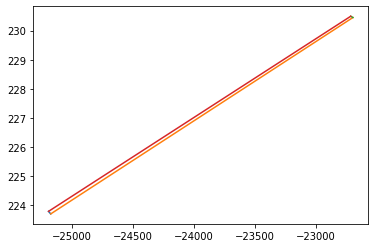

In [58]:
plt.plot([bl[0], tl[0]], [bl[1], tl[1]])
plt.plot([bl[0], br[0]], [bl[1], br[1]])
plt.plot([br[0], tr[0]], [br[1], tr[1]])
plt.plot([tl[0], tr[0]], [tl[1], tr[1]])

# Attempt To Project Runway Corner into Image

In [276]:
setHomeState(client, 0, 2980, 0)

In [277]:
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]

In [278]:
sh, sw, _ = ss.shape

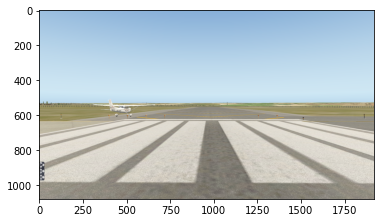

In [279]:
plt.imshow(ss)

In [280]:
mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T 
proj = np.reshape(client.getDREF("sim/graphics/view/projection_matrix_3d"), (4, 4)).T

In [281]:
br_h = np.append(np.array(br), 1.0)
br_eye = mv @ br_h
br_ndc = proj @ br_eye
br_ndc = br_ndc[:3] / br_ndc[3]
xp = sw * (br_ndc[0] * 0.5 + 0.5)
yp = sh - sh * (br_ndc[1] * 0.5 + 0.5)

In [282]:
def get_image_coord(pt, mv, proj, sh, sw):
    pt_h = np.append(np.array(pt), 1.0)
    pt_eye = mv @ pt_h
    pt_ndc = proj @ pt_eye
    pt_ndc = pt_ndc[:3] / pt_ndc[3]
    xp = sw * (pt_ndc[0] * 0.5 + 0.5)
    yp = sh - sh * (pt_ndc[1] * 0.5 + 0.5)
    return xp, yp

In [283]:
br_shifted = [br[0], br[1] - 1.75, br[2]]
tr_shifted = [tr[0], tr[1] - 1.75, tr[2]]
bl_shifted = [bl[0], bl[1] - 1.75, bl[2]]
tl_shifted = [tl[0], tl[1] - 1.75, tl[2]]

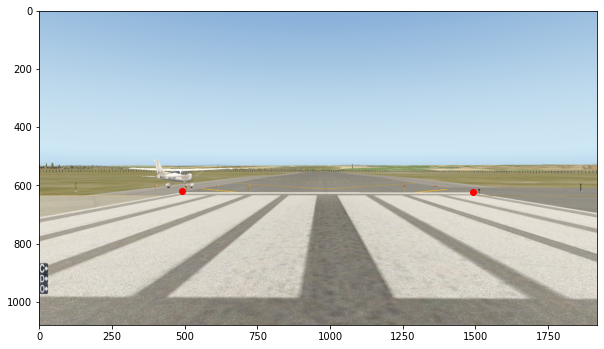

In [285]:
plt.figure(figsize=(10, 6))
xp1, yp1 = get_image_coord(tr_shifted, mv, proj, sh, sw)
xp2, yp2 = get_image_coord(br_shifted, mv, proj, sh, sw)
plt.imshow(ss)
plt.scatter([xp1, xp2], [yp1, yp2], c='red')

# Try Understanding What the Matrices Are

From XPlane DataRefs:
* sim/graphics/view/world_matrix: the current modelview matrix to draw in standard 'OGL' coordinates - valid only during draw callbacks
* sim/graphics/view/projection_matrix_3d: The current projection matrix during 3-d rendering - it keeps its value during 2-d rendering so youc can figure out how to apply text labels to 3-d stuff.

In [174]:
setHomeState(client, 0, 20, 0)
mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
print(mv)

[[ 5.92020035e-01 -1.74897327e-03  8.05921376e-01 -1.22560293e+04]
 [-3.43610090e-03  9.99983072e-01  4.69423505e-03 -4.68823853e+02]
 [-8.05915952e-01 -5.54830814e-03  5.92004001e-01 -4.01983672e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [163]:
setHomeState(client, 0, 20, 180)
mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
print(mv)

[[-5.92019796e-01 -1.74897863e-03 -8.05921555e-01  1.22575234e+04]
 [ 3.43609904e-03  9.99983072e-01 -4.69423831e-03  2.01504440e+01]
 [ 8.05916071e-01 -5.54830814e-03 -5.92003763e-01  4.02031562e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [165]:
print(mv @ np.append(np.array(bl), 1))

[-14.372778    -0.93276649 -48.60210904   1.        ]


In [166]:
setHomeState(client, 0, 20, 0)
proj = np.reshape(client.getDREF("sim/graphics/view/projection_matrix_3d"), (4, 4)).T
print(proj)

[[ 1.19175351  0.          0.          0.        ]
 [ 0.          2.11867285  0.          0.        ]
 [ 0.          0.         -1.00000799 -2.57435203]
 [ 0.          0.         -1.          0.        ]]


In [173]:
setHomeState(client, 0, 20, 0)
proj = np.reshape(client.getDREF("sim/graphics/view/projection_matrix_3d"), (4, 4)).T
print(proj)

[[ 1.19175351  0.          0.          0.        ]
 [ 0.          2.11867285  0.          0.        ]
 [ 0.          0.         -1.00000799 -2.58118796]
 [ 0.          0.         -1.          0.        ]]


In [176]:
print(mv @ np.append(np.array(bl), 1))

[15.07236166 -0.32908938 50.91379033  1.        ]


In [175]:
print(proj @ mv @ np.append(np.array(bl), 1))

[ 17.96253986  -0.69723273 -53.49538495 -50.91379033]


# Start Figuring Out Lines

In [217]:
setHomeState(client, 0, -60, 0)
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
sh, sw, _ = ss.shape

In [288]:
def get_image_coord(pt, sh, sw):
    mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
    proj = np.reshape(client.getDREF("sim/graphics/view/projection_matrix_3d"), (4, 4)).T

    pt_h = np.append(np.array(pt), 1.0)
    pt_eye = mv @ pt_h
    pt_ndc = proj @ pt_eye
    pt_ndc = pt_ndc[:3] / pt_ndc[3]
    xp = sw * (pt_ndc[0] * 0.5 + 0.5)
    yp = sh - sh * (pt_ndc[1] * 0.5 + 0.5)
    return xp, yp

In [239]:
closer_pt = 0.005 * np.array(br_shifted) + 0.995 * np.array(bl_shifted)

In [240]:
print(br_shifted)
print(bl_shifted)
print(closer_pt)

[-22699.7734375, 228.947509765625, 31943.748046875]
[-25174.408203125, 222.2095947265625, 33719.4765625]
[-25162.0350293     222.2432843   33710.59791992]


In [241]:
# Get pixel coordinates of corners of right edge lines
x1, y1 = get_image_coord(bl_shifted, sh, sw)
x2, y2 = get_image_coord(br_shifted, sh, sw)
x3, y3 = get_image_coord(closer_pt, sh, sw)
print(x1, y1)
print(x2, y2)
print(x3, y3)

1588.189644621331 639.8575339782483
978.5623096510992 544.7026573237348
1376.6215063177026 606.8345067130906


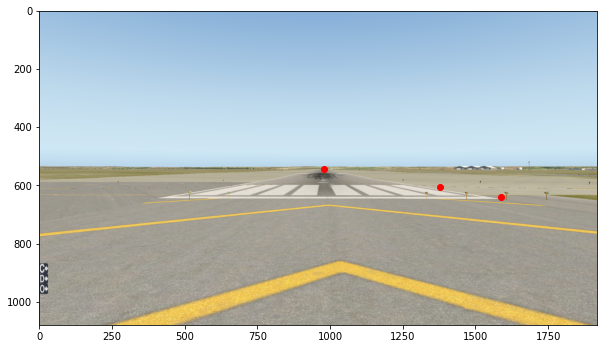

In [242]:
plt.figure(figsize=(10, 6))
plt.imshow(ss)
plt.scatter([x1, x2, x3], [y1, y2, y3], c='red')

In [221]:
line = np.cross(np.array([x1, y1, 1]), np.array([x2, y2, 1]))

In [222]:
def get_pixels(line, sw):
    a, b, c = line
    xs = np.arange(0, sw, 1)
    ys = [-(a / b) * x + (-c / b) for x in xs]
    return xs, ys

In [223]:
xs, ys = get_pixels(line, sw)

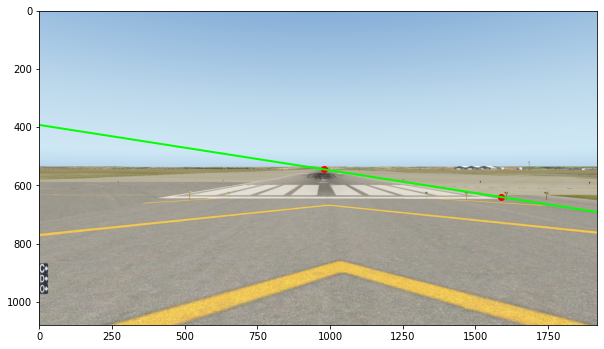

In [230]:
plt.figure(figsize=(10, 6))
plt.imshow(ss)
plt.scatter([x1, x2], [y1, y2], c='red')
plt.plot(xs, ys, c='lime', linewidth=2.0)

(-0.5, 1919.5, 1079.5, -0.5)

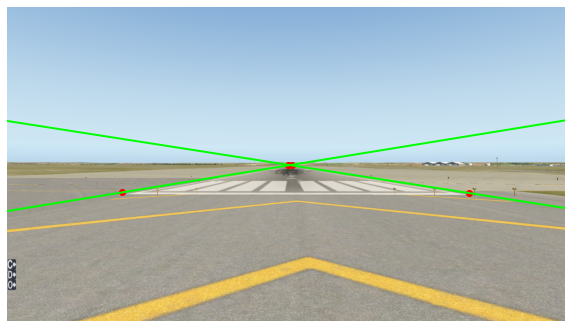

In [245]:
x1, y1 = get_image_coord(bl_shifted, sh, sw)
x2, y2 = get_image_coord(br_shifted, sh, sw)
x3, y3 = get_image_coord(tl_shifted, sh, sw)
x4, y4 = get_image_coord(tr_shifted, sh, sw)

line1 = np.cross(np.array([x1, y1, 1]), np.array([x2, y2, 1]))
line2 = np.cross(np.array([x3, y3, 1]), np.array([x4, y4, 1]))

xl1, yl1 = get_pixels(line1, sw)
xl2, yl2 = get_pixels(line2, sw)

plt.figure(figsize=(10, 6))
plt.imshow(ss)
plt.scatter([x1, x2], [y1, y2], c='red')
plt.scatter([x3, x4], [y3, y4], c='red')
plt.plot(xl1, yl1, c='lime', linewidth=2.0)
plt.plot(xl2, yl2, c='lime', linewidth=2.0)
plt.axis('off')

# Get Things Looking Good in Region for Collecting Data

In [324]:
setHomeState(client, 0, 1700, 0)
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
sh, sw, _ = ss.shape

(-0.5, 1919.5, 1079.5, -0.5)

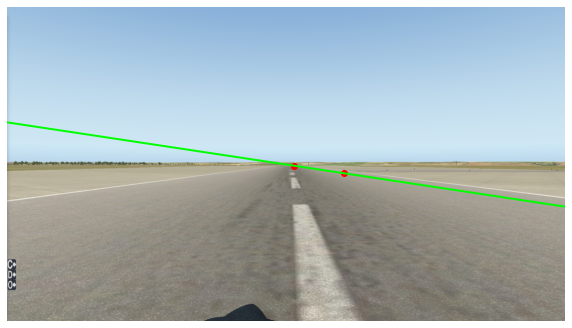

In [329]:
alpha = 0.6
shift = 1.5
brs = np.array(br) - np.array([0.0, shift, 0.0])
bls = np.array(bl) - np.array([0.0, shift, 0.0])
closer_pt = alpha * np.array(brs) + (1 - alpha) * np.array(bls)
x1, y1 = get_image_coord(brs, sh, sw)
x2, y2 = get_image_coord(closer_pt, sh, sw)
line = np.cross(np.array([x1, y1, 1]), np.array([x2, y2, 1]))
xs, ys = get_pixels(line, sw)
plt.figure(figsize=(10, 6))
plt.imshow(ss)
plt.scatter([x1, x2], [y1, y2], c='red')
plt.plot(xs, ys, c='lime', linewidth=2.0)
plt.axis('off')

In [395]:
setHomeState(client, 0, 680, -20)
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
sh, sw, _ = ss.shape

(-0.5, 1919.5, 1079.5, -0.5)

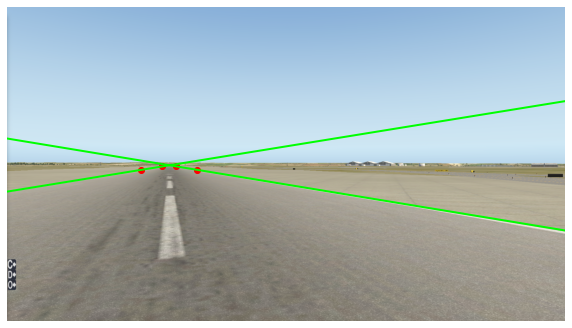

In [396]:
alpha1 = 0.5
alpha2 = 0.3
shift = 1.75
pt1 = alpha1 * np.array(br) + (1 - alpha1) * np.array(bl)
pt2 = alpha2 * np.array(br) + (1 - alpha2) * np.array(bl)
pt1_shifted = pt1 - np.array([0.0, shift, 0.0])
pt2_shifted = pt2 - np.array([0.0, shift, 0.0])
pt3 = alpha1 * np.array(tr) + (1 - alpha1) * np.array(tl)
pt4 = alpha2 * np.array(tr) + (1 - alpha2) * np.array(tl)
pt3_shifted = pt3 - np.array([0.0, shift, 0.0])
pt4_shifted = pt4 - np.array([0.0, shift, 0.0])
x1, y1 = get_image_coord(pt1_shifted, sh, sw)
x2, y2 = get_image_coord(pt2_shifted, sh, sw)
x3, y3 = get_image_coord(pt3_shifted, sh, sw)
x4, y4 = get_image_coord(pt4_shifted, sh, sw)
line1 = np.cross(np.array([x1, y1, 1]), np.array([x2, y2, 1]))
xs1, ys1 = get_pixels(line1, sw)
line2 = np.cross(np.array([x3, y3, 1]), np.array([x4, y4, 1]))
xs2, ys2 = get_pixels(line2, sw)
plt.figure(figsize=(10, 6))
plt.imshow(ss)
plt.scatter([x1, x2, x3, x4], [y1, y2, y3, y4], c='red')
plt.plot(xs1, ys1, c='lime', linewidth=2.0)
plt.plot(xs2, ys2, c='lime', linewidth=2.0)
plt.axis('off')


In [310]:
dtps = np.arange(0, 2800, 10)
ys = []
for dtp in dtps:
    setHomeState(client, 0, dtp, 0)
    time.sleep(0.25)
    ys.append(client.getDREF("sim/flightmodel/position/local_y")[0])


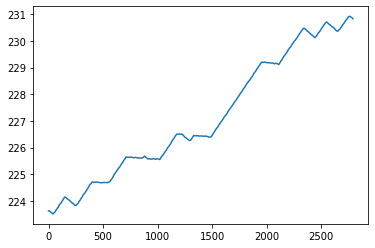

In [311]:
plt.plot(dtps, ys)

In [398]:
print(pt1_shifted)
print(pt2_shifted)
print(pt3_shifted)
print(pt4_shifted)

[-23937.09082031    225.32855225  32831.61230469]
[-24432.01777344    223.98096924  33186.75800781]
[-23954.87792969    225.39438629  32806.69628906]
[-24449.80410156    224.0555954   33161.92558594]


# Save off these points!

In [ ]:
left_edge_1 = [-23954.87792969, 225.3943862, 32806.69628906]
left_edge_2 = [-24449.80410156, 224.0555954, 33161.92558594]
right_edge_1 = [-23937.09082031, 225.32855225, 32831.61230469]
right_edge_2 = [-24432.01777344, 223.98096924, 33186.75800781]

# Visualize Runway Points

In [7]:
# Move plane to runway points and get the x, y, z values
ll_pt1 = [47.196736, -119.332917]
ll_pt2 = [47.212778, -119.300297]
ll_center = [47.204757, -119.316607]

# Trying to figure out how to convert to correct frames

In [48]:
client.getDREF("sim/flightmodel/position/local_x")[0]

-22717.5625

In [49]:
client.getDREF("sim/multiplayer/position/plane1_x")[0]

-22717.5625

In [8]:
def put_on_ground():
    curr_agly = client.getDREF("sim/flightmodel/position/y_agl")[0]
    curr_localy = client.getDREF("sim/flightmodel/position/local_y")[0]
    client.sendDREF("sim/flightmodel/position/local_y",
                    curr_localy - curr_agly)

In [20]:
client.sendDREF('sim/flightmodel/position/latitude', ll_pt1[0])
client.sendDREF('sim/flightmodel/position/longitude', ll_pt1[1])
client.sendPOSI(ll_pt2)

In [21]:
put_on_ground()